# **Contrastive learning based MRI segmentation under arbitrary distortion**


#  Install dependencies
---


In [1]:
Notebook_version = '1.0'
Network = 'MSC_Project'

from builtins import any as b_any

def get_requirements_path():
    # Store requirements file in 'contents' directory 
    current_dir = os.getcwd()
    dir_count = current_dir.count('/') - 1
    path = '../' * (dir_count) + 'requirements.txt'
    return path

def filter_files(file_list, filter_list):
    filtered_list = []
    for fname in file_list:
        if b_any(fname.split('==')[0] in s for s in filter_list):
            filtered_list.append(fname)
    return filtered_list

def build_requirements_file(before, after):
    path = get_requirements_path()

    # Exporting requirements.txt for local run
    !pip freeze > $path

    # Get minimum requirements file
    df = pd.read_csv(path, delimiter = "\n")
    mod_list = [m.split('.')[0] for m in after if not m in before]
    req_list_temp = df.values.tolist()
    req_list = [x[0] for x in req_list_temp]

    # Replace with package name and handle cases where import name is different to module name
    mod_name_list = [['sklearn', 'scikit-learn'], ['skimage', 'scikit-image']]
    mod_replace_list = [[x[1] for x in mod_name_list] if s in [x[0] for x in mod_name_list] else s for s in mod_list] 
    filtered_list = filter_files(req_list, mod_replace_list)

    file=open(path,'w')
    for item in filtered_list:
        file.writelines(item + '\n')

    file.close()

import sys
before = [str(m) for m in sys.modules]

#@markdown ##Install dependencies

#Here, we install libraries which are not already included in Colab.
!git clone https://github.com/santhoshhollap/MSC_Project
import os
os.chdir('MSC_Project/')
!pip install -r requirements.txt
!pip install fpdf
!pip install lpips

import lpips
from PIL import Image
import imageio
from skimage import data
from skimage import exposure
from skimage.exposure import match_histograms
import os.path
import numpy as np
from matplotlib import pyplot as plt
import urllib
import os, random
import shutil 
import zipfile
from tifffile import imread, imsave
import time
import sys
from pathlib import Path
import pandas as pd
import csv
from glob import glob
from scipy import signal
from scipy import ndimage
from skimage import io
from sklearn.linear_model import LinearRegression
from skimage.util import img_as_uint
import matplotlib as mpl
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio as psnr
from astropy.visualization import simple_norm
from skimage import img_as_float32
from skimage.util import img_as_ubyte
from tqdm import tqdm 
from fpdf import FPDF, HTMLMixin
from datetime import datetime
import subprocess
from pip._internal.operations.freeze import freeze

# Colors for the warning messages
class bcolors:
  WARNING = '\033[31m'

#Disable some of the tensorflow warnings
import warnings
warnings.filterwarnings("ignore")

print('----------------------------')
print("Libraries installed")



# average function
def Average(lst): 
    return sum(lst) / len(lst) 

def perceptual_diff(im0, im1, network, spatial):

  tensor0 = lpips.im2tensor(im0)
  tensor1 = lpips.im2tensor(im1)
  # Set up the loss function we will use
  loss_fn = lpips.LPIPS(net=network, spatial=spatial, verbose=False)

  diff = loss_fn.forward(tensor0, tensor1)

  return diff

# Build requirements file for local run
after = [str(m) for m in sys.modules]
build_requirements_file(before, after)

Cloning into 'MSC_Project'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 184 (delta 13), reused 36 (delta 5), pack-reused 110
Receiving objects: 100% (184/184), 10.00 MiB | 18.51 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 676 kB 39.6 MB/s 
     |████████████████████████████████| 1.8 MB 57.1 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
     |████████████████████████████████| 181 kB 70.8 MB/s 
     |████████████████████████████████| 158 kB 67.8 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 157 kB 75.8 MB/s 
     |████████████████████████████████| 157 kB 70.7 MB/s 
     |████████████████████████████████| 157 kB 71.5 MB/s 
     |████████████████████████████████| 157 kB 

## Mount your Google Drive


In [2]:
#@markdown ##Play the cell to connect your Google Drive to Colab

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Paths for training, predictions and results


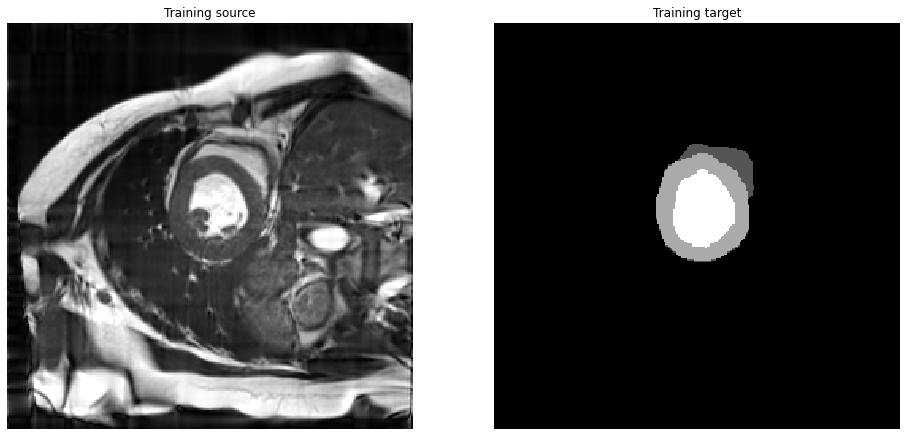

In [3]:
import cv2
import os

#@markdown ###Training pipeline:
#choose from [pix2pix,cyclegan,cyclemedgan,proposed]
Train_Mode = "proposed"  #@param {type:"string"}

#choose from [pix2pix,cycle_gan,cycle_mgan,proposed]
model_Mode = "proposed"  #@param {type:"string"}

#@markdown ###Path to training images:

Training_source = "/content/gdrive/MyDrive/MRI/ACDC_Sample_Data/Distortion" #@param {type:"string"}
#InputFile = Training_source+"/*.png"

Training_target = "/content/gdrive/MyDrive/MRI/ACDC_Sample_Data/Segmented_GT" #@param {type:"string"}
#OutputFile = Training_target+"/*.png"


#Define where the patch file will be saved
base = "/content"

# model name and path
#@markdown ###Name of the model and path to model folder:
model_name = "proposed" #@param {type:"string"}
model_path = "/content/gdrive/MyDrive/MRI/final_test" #@param {type:"string"}

# other parameters for training.
#@markdown ###Training Parameters
#@markdown Number of epochs:
number_of_epochs =  100#@param {type:"number"}

#@markdown ###Advanced Parameters

patch_size =  256#@param {type:"number"} # in pixels
batch_size =  2#@param {type:"number"}
initial_learning_rate = 0.0002 #@param {type:"number"}


#here we check that no model with the same name already exist, if so delete
if os.path.exists(model_path+'/'+model_name):
  print(bcolors.WARNING +"!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")
  print(bcolors.WARNING +"To continue training "+model_name+", choose a new model_name here, and load "+model_name+" in section 3.3")
  

Saving_path= "/content/"+model_name

if os.path.exists(Saving_path):
  shutil.rmtree(Saving_path)
os.makedirs(Saving_path)


if Train_Mode in ["pix2pix","proposed"]:
  imageA_folder = Saving_path+"/A"
  os.makedirs(imageA_folder)

  imageB_folder = Saving_path+"/B"
  os.makedirs(imageB_folder)

  imageAB_folder = Saving_path+"/AB"
  os.makedirs(imageAB_folder)

  TrainA_Folder = Saving_path+"/A/train"
  os.makedirs(TrainA_Folder)
    
  TrainB_Folder = Saving_path+"/B/train"
  os.makedirs(TrainB_Folder)
else:
  TrainA_Folder = Saving_path+"/trainA"
  if os.path.exists(TrainA_Folder):
    shutil.rmtree(TrainA_Folder)
  os.makedirs(TrainA_Folder)
    
  TrainB_Folder = Saving_path+"/trainB"
  if os.path.exists(TrainB_Folder):
    shutil.rmtree(TrainB_Folder)
  os.makedirs(TrainB_Folder)


# Here we disable pre-trained model by default (in case the  cell is not ran)
Use_pretrained_model = False

# Here we disable data augmentation by default (in case the cell is not ran)

Use_Data_augmentation = False

# This will display a randomly chosen dataset input and output
random_choice = random.choice(os.listdir(Training_source))
x = io.imread(Training_source+"/"+random_choice)

#Find image XY dimension
Image_Y = x.shape[0]
Image_X = x.shape[1]

Image_min_dim = min(Image_Y, Image_X)

#Hyperparameters failsafes
if patch_size > min(Image_Y, Image_X):
  patch_size = min(Image_Y, Image_X)
  print (bcolors.WARNING + " Your chosen patch_size is bigger than the xy dimension of your image; therefore the patch_size chosen is now:",patch_size)

# Here we check that patch_size is divisible by 4
if not patch_size % 4 == 0:
    patch_size = ((int(patch_size / 4)-1) * 4)
    print (bcolors.WARNING + " Your chosen patch_size is not divisible by 4; therefore the patch_size chosen is now:",patch_size)

# Here we check that patch_size is at least bigger than 256
if patch_size < 256:
  patch_size = 256
  print (bcolors.WARNING + " Your chosen patch_size is too small; therefore the patch_size chosen is now:",patch_size)

y = io.imread(Training_target+"/"+random_choice)

n_channel_x = 1 if x.ndim == 2 else x.shape[-1]
n_channel_y = 1 if y.ndim == 2 else y.shape[-1]

if n_channel_x == 1:
  cmap_x = 'gray'
else:
  cmap_x = None

if n_channel_y == 1:
  cmap_y = 'gray'
else:
  cmap_y = None

f=plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(x, cmap=cmap_x, interpolation='nearest')
plt.title('Training source')
plt.axis('off');

plt.subplot(1,2,2)
plt.imshow(y, cmap=cmap_y, interpolation='nearest')
plt.title('Training target')
plt.axis('off');



##  Using weights from a pre-trained model as initial weights (use only to continue the paused training)



In [ ]:
# @markdown ##Loading weights from a pre-trained network


Use_pretrained_model = False #@param {type:"boolean"}


#@markdown ###If yes, please provide the path to the model folder:
pretrained_model_path = "" #@param {type:"string"}

# --------------------- Check if we load a previously trained model ------------------------
if Use_pretrained_model:

  h5_file_path = os.path.join(pretrained_model_path, "latest_net_G.pth")
  

# --------------------- Check the model exist ------------------------

  if not os.path.exists(h5_file_path):
    print(bcolors.WARNING+'WARNING: Pretrained model does not exist')
    Use_pretrained_model = False
    print(bcolors.WARNING+'No pretrained network will be used.')

  if os.path.exists(h5_file_path):
    print("Pretrained model "+os.path.basename(pretrained_model_path)+" was found and will be loaded prior to training.")
    
else:
  print(bcolors.WARNING+'No pretrained network will be used.')



No pretrained network will be used.


## Train the network
---

##  Prepare the training data for training





In [4]:
#@markdown ##Prepare the data for training

if Train_Mode in ["pix2pix","proposed"]:
  # --------------------- Here we load the augmented data or the raw data ------------------------
  Use_Data_augmentation = False
  if Use_Data_augmentation:
    Training_source_dir = Training_source_augmented
    Training_target_dir = Training_target_augmented

  if not Use_Data_augmentation:
    Training_source_dir = Training_source
    Training_target_dir = Training_target
  # --------------------- ------------------------------------------------

  print("Data preparation in progress")

  if os.path.exists(model_path+'/'+model_name):
    shutil.rmtree(model_path+'/'+model_name)
  os.makedirs(model_path+'/'+model_name)

  #--------------- Here we move the files to trainA and train B ---------


  print('Copying training source data...')
  for f in tqdm(os.listdir(Training_source_dir)):
      shutil.copyfile(Training_source_dir+"/"+f, TrainA_Folder+"/"+f)

  print('Copying training target data...')
  for f in tqdm(os.listdir(Training_target_dir)):
      shutil.copyfile(Training_target_dir+"/"+f, TrainB_Folder+"/"+f)

  #---------------------------------------------------------------------

  #--------------- Here we combined A and B images---------
  os.chdir("/content")
  !python MSC_Project/datasets/combine_A_and_B.py --fold_A "$imageA_folder" --fold_B "$imageB_folder" --fold_AB "$imageAB_folder"


  number_of_epochs_lr_stable = int(number_of_epochs/2)
  number_of_epochs_lr_decay = int(number_of_epochs/2)

  if Use_pretrained_model :
    for f in os.listdir(pretrained_model_path):
      if (f.startswith("latest_net_")):      
        shutil.copyfile(pretrained_model_path+"/"+f, model_path+'/'+model_name+"/"+f)


  print('------------------------')
  print("Data ready for training")
else:

  print("Data preparation in progress - cyclegan/cyclemed")

  if os.path.exists(model_path+'/'+model_name):
    shutil.rmtree(model_path+'/'+model_name)
  os.makedirs(model_path+'/'+model_name)

  #--------------- Here we move the files to trainA and train B ---------


  for f in os.listdir(Training_source):
    shutil.copyfile(Training_source+"/"+f, TrainA_Folder+"/"+f)

  for files in os.listdir(Training_target):
    shutil.copyfile(Training_target+"/"+files, TrainB_Folder+"/"+files)

  #---------------------------------------------------------------------

  # CycleGAN use number of EPOCH withouth lr decay and number of EPOCH with lr decay


  number_of_epochs_lr_stable = int(number_of_epochs/2)
  number_of_epochs_lr_decay = int(number_of_epochs/2)

  if Use_pretrained_model :
    for f in os.listdir(pretrained_model_path):
      if (f.startswith("latest_net_")):      
        shutil.copyfile(pretrained_model_path+"/"+f, model_path+'/'+model_name+"/"+f)

  print("Data ready for training")



Data preparation in progress
Copying training source data...


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


Copying training target data...


100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


[fold_A] =  /content/proposed/A
[fold_B] =  /content/proposed/B
[fold_AB] =  /content/proposed/AB
[num_imgs] =  1000000
[use_AB] =  False
[no_multiprocessing] =  False
split = train, use 4/4 images
split = train, number of images = 4
------------------------
Data ready for training


## Start Training
---


In [5]:
#@markdown ##Start training

start = time.time()

os.chdir("/content")

#----- Start the training ------------------------------------
if not Use_pretrained_model:
  if Train_Mode in ["pix2pix","proposed"]:
    !python MSC_Project/train.py --dataroot "$imageAB_folder" --name $model_name --model "$model_Mode" --batch_size $batch_size --preprocess scale_width_and_crop --load_size $Image_min_dim --crop_size $patch_size --checkpoints_dir "$model_path"  --no_html --n_epochs $number_of_epochs_lr_stable --n_epochs_decay $number_of_epochs_lr_decay --lr $initial_learning_rate --display_id 0 --save_epoch_freq 5 --input_nc 1 --output_nc 1
  else:
    print("training cycle - no pretrain")
    !python MSC_Project/train.py --dataroot "$Saving_path" --input_nc 1 --name $model_name --model "$model_Mode" --batch_size $batch_size --preprocess scale_width_and_crop --load_size $Image_min_dim --crop_size $patch_size --checkpoints_dir "$model_path"  --no_html --n_epochs $number_of_epochs_lr_stable --n_epochs_decay $number_of_epochs_lr_decay --lr $initial_learning_rate --display_id 0 --save_epoch_freq 5 --no_flip --output_nc 1

if Use_pretrained_model:
  if Train_Mode in ["pix2pix","proposed"]:
    !python MSC_Project/train.py --dataroot "$imageAB_folder" --name $model_name --model "$model_Mode" --batch_size $batch_size --preprocess scale_width_and_crop --load_size $Image_min_dim --crop_size $patch_size --checkpoints_dir "$model_path"  --no_html --n_epochs $number_of_epochs_lr_stable --n_epochs_decay $number_of_epochs_lr_decay --lr $initial_learning_rate --display_id 0 --save_epoch_freq 5 --continue_train --input_nc 1 --output_nc 1
  else:
    print("training cycle - pretrain")
    !python MSC_Project/train.py --dataroot "$Saving_path" --input_nc 1 --name $model_name --model "$model_Mode" --batch_size $batch_size --preprocess scale_width_and_crop --load_size $Image_min_dim --crop_size $patch_size --checkpoints_dir "$model_path"  --no_html --n_epochs $number_of_epochs_lr_stable --n_epochs_decay $number_of_epochs_lr_decay --lr $initial_learning_rate --display_id 0 --save_epoch_freq 5 --continue_train --no_flip --output_nc 1


#---------------------------------------------------------

print("Training, done.")

# Displaying the time elapsed for training
dt = time.time() - start
mins, sec = divmod(dt, 60) 
hour, mins = divmod(mins, 60) 
print("Time elapsed:",hour, "hour(s)",mins,"min(s)",round(sec),"sec(s)")



----------------- Options ---------------
               batch_size: 2                             	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: /content/gdrive/MyDrive/MRI/final_test	[default: ./checkpoints]
           continue_train: False                         
                crop_size: 256                           
                 dataroot: /content/proposed/AB          	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 0                             	[default: 1]
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
             

## Generate prediction(s) from unseen dataset



In [9]:
#@markdown ### Provide the path to your dataset and to the folder where the predictions are saved, then play the cell to predict outputs from your unseen images.
import glob
import os.path

latest = "latest"

Data_folder = "/content/gdrive/MyDrive/MRI/ACDC_Sample_Data/Distortion" #@param {type:"string"}
Result_folder = "/content/gdrive/MyDrive/MRI/final_test" #@param {type:"string"}
#@markdown ### choose Train mode.
#choose from [pix2pix,cyclegan,cyclemedgan,proposed]
Train_Mode = "cyclemedgan"  #@param {type:"string"}

#@markdown ### choose model mode.
model_Mode = "cycle_mgan"#@param {type:"string"}
#choose from [pix2pix,proposed,cycle_gan,cycle_mgan]

# model name and path
#@markdown ###Do you want to use the current trained model?
Use_the_current_trained_model = False #@param {type:"boolean"}

#@markdown ###If not, please provide the path to the model folder:

Prediction_model_folder = "/content/gdrive/MyDrive/MRI/trained_models/cyclemedGAN" #@param {type:"string"}

#@markdown ###What model checkpoint would you like to use?

checkpoint = latest#@param {type:"raw"}

#@markdown ###Advanced Parameters

patch_size =  256#@param {type:"number"} # in pixels

#Here we find the loaded model name and parent path
Prediction_model_name = os.path.basename(Prediction_model_folder)
Prediction_model_path = os.path.dirname(Prediction_model_folder)

#here we check if we use the newly trained network or not
if (Use_the_current_trained_model): 
  print("Using current trained network")
  Prediction_model_name = model_name
  Prediction_model_path = model_path

if not patch_size % 256 == 0:
  patch_size = ((int(patch_size / 256)) * 256)
  print (" Your image dimensions are not divisible by 256; therefore your images have now been resized to:",patch_size_QC)

if patch_size < 256:
  patch_size = 256

#here we check if the model exists
full_Prediction_model_path = Prediction_model_path+'/'+Prediction_model_name+'/'

if os.path.exists(full_Prediction_model_path):
  print("The "+Prediction_model_name+" network will be used.")
else:
  W  = '\033[0m'  # white (normal)
  R  = '\033[31m' # red
  print(R+'!! WARNING: The chosen model does not exist !!'+W)
  print('Please make sure you provide a valid model path and model name before proceeding further.')

Nb_Checkpoint = len(glob.glob(os.path.join(full_Prediction_model_path, '*G.pth')))+1

if not checkpoint == "latest":

  if  checkpoint < 10:
    checkpoint = 5

  if not checkpoint % 5 == 0:
    checkpoint = ((int(checkpoint / 5)-1) * 5)
    print (bcolors.WARNING + " Your chosen checkpoints is not divisible by 5; therefore the checkpoints chosen is now:",checkpoints)
  
  if checkpoint == Nb_Checkpoint*5:
    checkpoint = "latest"

  if checkpoint > Nb_Checkpoint*5:
    checkpoint = "latest"

# Here we need to move the data to be analysed so that pix2pix can find them

Saving_path_prediction= "/content/"+Prediction_model_name

if os.path.exists(Saving_path_prediction):
  shutil.rmtree(Saving_path_prediction)
os.makedirs(Saving_path_prediction)

if Train_Mode in ["pix2pix","proposed"]:
  imageA_folder = Saving_path_prediction+"/A"
  os.makedirs(imageA_folder)

  imageB_folder = Saving_path_prediction+"/B"
  os.makedirs(imageB_folder)

  imageAB_folder = Saving_path_prediction+"/AB"
  os.makedirs(imageAB_folder)

  testAB_Folder = Saving_path_prediction+"/AB/test"
  os.makedirs(testAB_Folder)

  testA_Folder = Saving_path_prediction+"/A/test"
  os.makedirs(testA_Folder)
    
  testB_Folder = Saving_path_prediction+"/B/test"
  os.makedirs(testB_Folder)
  Normalisation_prediction_source = "None"
  if Normalisation_prediction_source == "None":
    for files in os.listdir(Data_folder):
      shutil.copyfile(Data_folder+"/"+files, testA_Folder+"/"+files)
      shutil.copyfile(Data_folder+"/"+files, testB_Folder+"/"+files)
  
  # Here we create a merged A / A image for the prediction
  os.chdir("/content")
  !python MSC_Project/datasets/combine_A_and_B.py --fold_A "$imageA_folder" --fold_B "$imageB_folder" --fold_AB "$imageAB_folder"

  # Here we count how many images are in our folder to be predicted and we had a few
  Nb_files_Data_folder = len(os.listdir(Data_folder)) +10

  # This will find the image dimension of a randomly choosen image in Data_folder 
  random_choice = random.choice(os.listdir(Data_folder))
  x = imageio.imread(Data_folder+"/"+random_choice)

  #Find image XY dimension
  Image_Y = x.shape[0]
  Image_X = x.shape[1]

  Image_min_dim = min(Image_Y, Image_X)

  os.chdir("/content")

  !python MSC_Project/test.py --dataroot "$imageAB_folder" --name "$Prediction_model_name" --model "$model_Mode" --no_dropout --preprocess scale_width --load_size $Image_min_dim --crop_size $patch_size --results_dir "$Result_folder" --checkpoints_dir "$Prediction_model_path" --num_test $Nb_files_Data_folder --epoch $checkpoint --input_nc 1 --output_nc 1

  #-----------------------------------------------------------------------------------

  Checkpoint_name = "test_"+str(checkpoint)


  Prediction_results_folder = Result_folder+"/"+Prediction_model_name+"/"+Checkpoint_name+"/images"

  Prediction_results_images = os.listdir(Prediction_results_folder)

  for f in Prediction_results_images:  
    if (f.endswith("_real_B.png")):    
      os.remove(Prediction_results_folder+"/"+f)

else:
  Saving_path_Data_folder = Saving_path_prediction+"/testA"

  if os.path.exists(Saving_path_Data_folder):
    shutil.rmtree(Saving_path_Data_folder)
  os.makedirs(Saving_path_Data_folder)

  for files in os.listdir(Data_folder):
      shutil.copyfile(Data_folder+"/"+files, Saving_path_Data_folder+"/"+files)


  Nb_files_Data_folder = len(os.listdir(Data_folder)) +10



  #Here we copy and rename the checkpoint to be used

  shutil.copyfile(full_Prediction_model_path+"/"+str(checkpoint)+"_net_G_A.pth", full_Prediction_model_path+"/"+str(checkpoint)+"_net_G.pth")


  # This will find the image dimension of a randomly choosen image in Data_folder 
  random_choice = random.choice(os.listdir(Data_folder))
  x = imageio.imread(Data_folder+"/"+random_choice)

  #Find image XY dimension
  Image_Y = x.shape[0]
  Image_X = x.shape[1]

  Image_min_dim = min(Image_Y, Image_X)

  print(Image_min_dim)

  os.chdir("/content")

  !python MSC_Project/test.py --dataroot "$Saving_path_Data_folder" --name "$Prediction_model_name" --model test --no_dropout --preprocess scale_width --load_size $Image_min_dim --crop_size $Image_min_dim --results_dir "$Result_folder" --checkpoints_dir "$Prediction_model_path" --num_test $Nb_files_Data_folder --epoch $checkpoint --input_nc 1 --output_nc 1




The cyclemedGAN network will be used.
256
----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: /content/gdrive/MyDrive/MRI/trained_models	[default: ./checkpoints]
                crop_size: 256                           
                 dataroot: /content/cyclemedGAN/testA    	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 1                             	[default: 3]
                  isTrain: False      

##  Inspect the predicted output
---



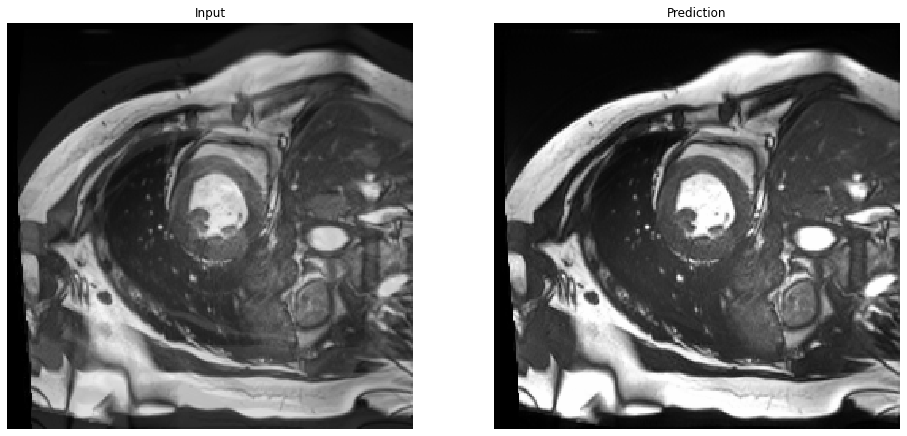

In [10]:
# @markdown ##Run this cell to display a randomly chosen input and its corresponding predicted output.
import os
# This will display a randomly chosen dataset input and predicted output
random_choice = random.choice(os.listdir(Data_folder))


random_choice_no_extension = os.path.splitext(random_choice)

if Train_Mode in ["pix2pix","proposed"]:
  x = imageio.imread(Result_folder+"/"+Prediction_model_name+"/test_"+str(checkpoint)+"/images/"+random_choice_no_extension[0]+"_real_A.png")


  y = imageio.imread(Result_folder+"/"+Prediction_model_name+"/test_"+str(checkpoint)+"/images/"+random_choice_no_extension[0]+"_fake_B.png")
else:
  x = imageio.imread(Result_folder+"/"+Prediction_model_name+"/test_"+str(checkpoint)+"/images/"+random_choice_no_extension[0]+"_real.png")

  y = imageio.imread(Result_folder+"/"+Prediction_model_name+"/test_"+str(checkpoint)+"/images/"+random_choice_no_extension[0]+"_fake.png")

f=plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(x, interpolation='nearest')
plt.title('Input')
plt.axis('off');

plt.subplot(1,2,2)
plt.imshow(y, interpolation='nearest')
plt.title('Prediction')
plt.axis('off');
